In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
%matplotlib inline

listings = pd.read_csv('./data/listings.csv')
calendar = pd.read_csv('./data/calendar.csv')
reviews = pd.read_csv('./data/reviews.csv')

<h2>Question 1: What features in the dataset have the biggest impact on price?</h2>

I will determine which features have the greatest impact on price by creating a simple linear regression model and using the trained coefficients of the model to interpret their respective impact.

I will begin by once again by converting the price to integers. Also, I drop any rows that do not have a price because this is the feature we are trying to predict.

In [37]:
dfmodel = listings.copy()
dfmodel['price'] = dfmodel['price'].map(lambda p: int(p[1:-3].replace(",", "")))
dfmodel.dropna(subset=['price']);

Firstly, I will drop any columns that are irrelevant, redundant, have too few rows, or give the model the same information that it is trying to predict. 

Then I create a heatmap to see which non-categorical features have the strongest correlation with price.

In [38]:
dfmodel = dfmodel.drop(['id','listing_url','scrape_id','last_scraped','name','description','experiences_offered','picture_url',
             'host_id','host_name','host_since','host_location','host_thumbnail_url','host_picture_url','street','neighbourhood',
             'neighbourhood_group_cleansed','city','state','zipcode','market','smart_location','country_code','country',
             'latitude','longitude','is_location_exact','square_feet','weekly_price','monthly_price','calendar_updated','has_availability',
             'calendar_last_scraped','first_review','last_review','requires_license','license','jurisdiction_names','host_listings_count'],axis=1)


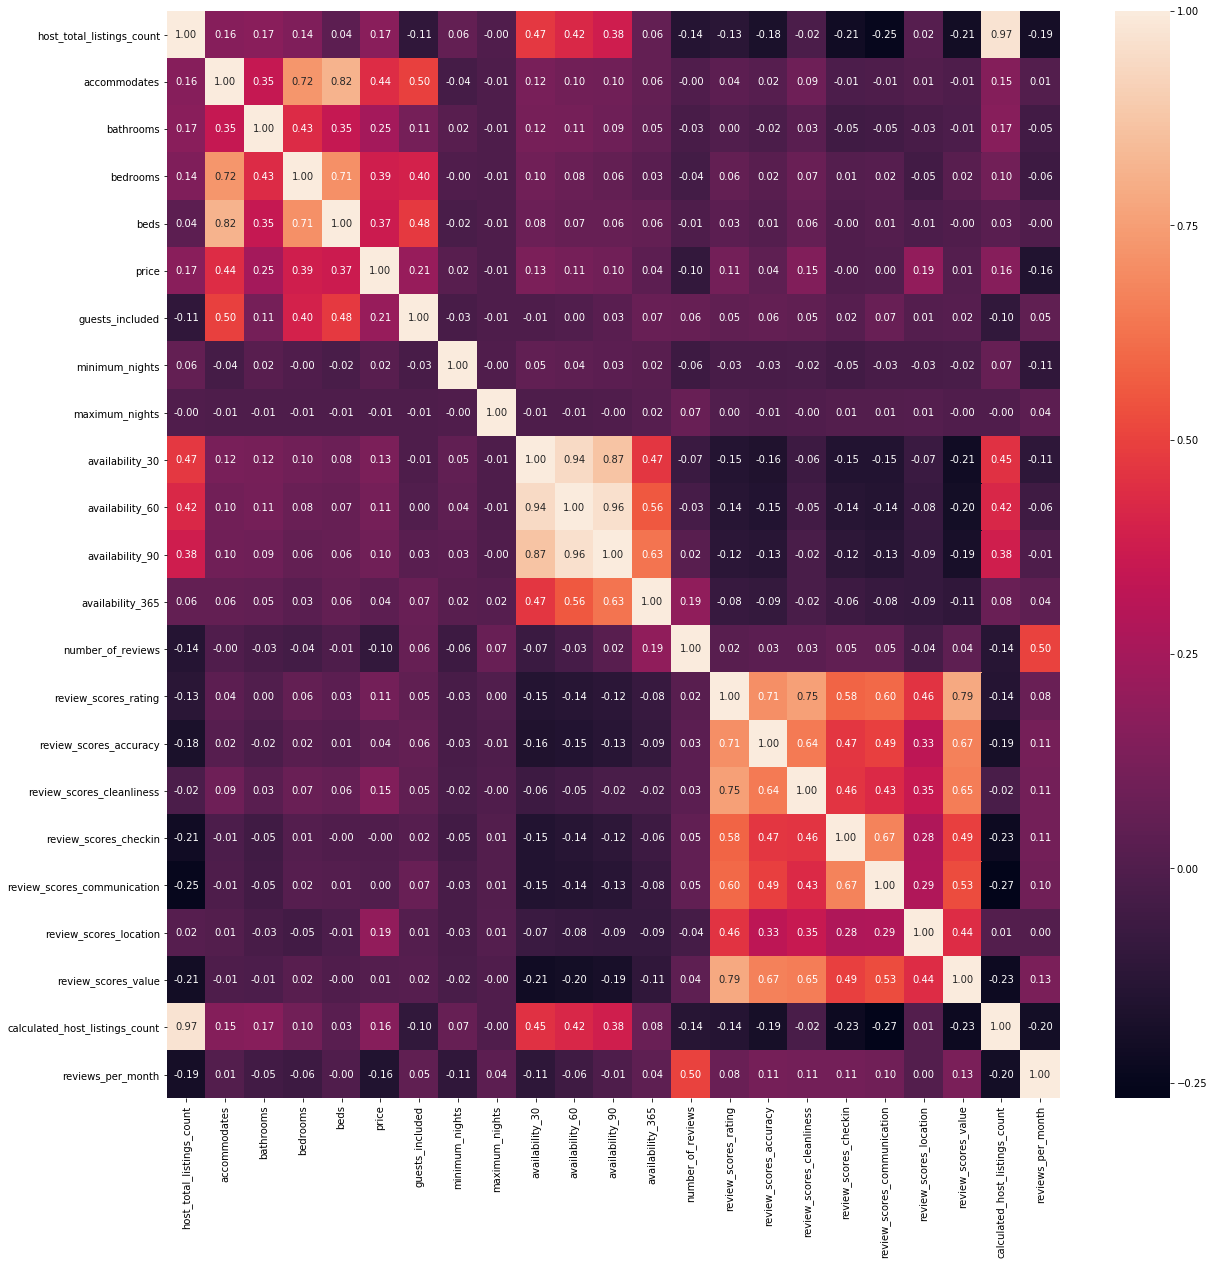

In [39]:
fig, ax = plt.subplots(figsize=(20,20))    
sns.heatmap(dfmodel.corr(), annot=True, fmt=".2f",ax=ax);

Now I can split the data into numeric data and categorical data, because each will be handled differently. And then split the numeric data into a target variable, price, and the training features. I got a negative r-squared value when I used all values stored in modelnum dataframe, so I use the seaborn figure to just select the most correlated variables. 

I use a fill_mean lambda function to impute the values for missing data. This is required for the sklearn model to be trained, and yields better results than dropping rows with missing data.

In [40]:
model_cat = dfmodel.select_dtypes(include='object')
model_num = dfmodel.select_dtypes(exclude='object')
y = model_num['price']
X = model_num[['accommodates','host_total_listings_count','number_of_reviews','review_scores_rating','guests_included',
              'bathrooms','bedrooms','beds','review_scores_accuracy','review_scores_cleanliness',
              'review_scores_checkin','review_scores_value']]
fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean, axis=0)

In [41]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.18495786651013746 on 1076 values.'

0.1849 is okay for a first attempt, but I was expecting better. From the seaborn correlation figure I can see that some features like beds and accommodates are highly related to price. So I will try retraining the model again, but this time drop all the outliers. This following one liner will drop all rows which have a price more than 3 times the absolute value of the standard deviation. 

In [42]:
dfmodel = dfmodel[np.abs(dfmodel.price-dfmodel.price.mean()) <= (3*dfmodel.price.std())]

In [43]:
model_cat = dfmodel.select_dtypes(include='object')
model_num = dfmodel.select_dtypes(exclude='object')
y = model_num['price']
X = model_num[['accommodates','host_total_listings_count','number_of_reviews','review_scores_rating','guests_included',
              'bathrooms','bedrooms','beds','review_scores_accuracy','review_scores_cleanliness',
              'review_scores_checkin','review_scores_value']]
fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean, axis=0)

In [44]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.4082506323040699 on 1066 values.'

Great, that is much better! Now I will try to add the amenities features to the training features. This took quite a long time to figure out how to do. In the end, Aleksey Bilogur's Modeling Prices kernel on Kaggle helped me find the solution. The amenities feature was combined together in strings that need to be parsed.

In [45]:
a = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")])
)
possible_vals = np.unique(np.concatenate(a.map(lambda amns: amns.split("|"))))[1:]

In [46]:
amenity = np.array([model_cat['amenities'].map(lambda amns: amn in amns) for amn in possible_vals])
amenity = amenity.T
amenitydf = pd.DataFrame(data=amenity, columns=possible_vals)
X = pd.concat([X.reset_index(drop=True), amenitydf.reset_index(drop=True)],axis=1)

In [47]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model with amenities added was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model with amenities added was 0.5156275009712186 on 1066 values.'

Even better! Now I will one hot encode the categorical features to add them to the training set. One hot encoding is necessary to learn on categorical data. 

In [48]:
df = model_cat[['neighbourhood_cleansed','room_type', 'bed_type','host_is_superhost','require_guest_phone_verification','host_identity_verified']]
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
x = pd.concat([df.reset_index(drop=True),X.reset_index(drop=True)],axis=1)
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)


In [49]:
"The r-squared score for the model using additional categorical variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using additional categorical variables was 0.632361740510893 on 1066 values.'

Okay, now with the model trained, I want to take a look at the coefficient weights for interpretation and graphing purposes.

In [50]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['columns'] = X_train.columns
    coefs_df['coefficient_influence'] = lm_model.coef_
    coefs_df['absolute_value_coefficients'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('absolute_value_coefficients', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,columns,coefficient_influence,absolute_value_coefficients
12,neighbourhood_cleansed_Leather District,110.073569,110.073569
1,neighbourhood_cleansed_Bay Village,93.239834,93.239834
0,neighbourhood_cleansed_Back Bay,76.914336,76.914336
20,neighbourhood_cleansed_South Boston Waterfront,75.142890,75.142890
7,neighbourhood_cleansed_Downtown,66.493630,66.493630
25,room_type_Shared room,-62.191919,62.191919
2,neighbourhood_cleansed_Beacon Hill,61.542595,61.542595
24,room_type_Private room,-49.728878,49.728878
31,require_guest_phone_verification_t,48.810164,48.810164
21,neighbourhood_cleansed_South End,44.296038,44.296038


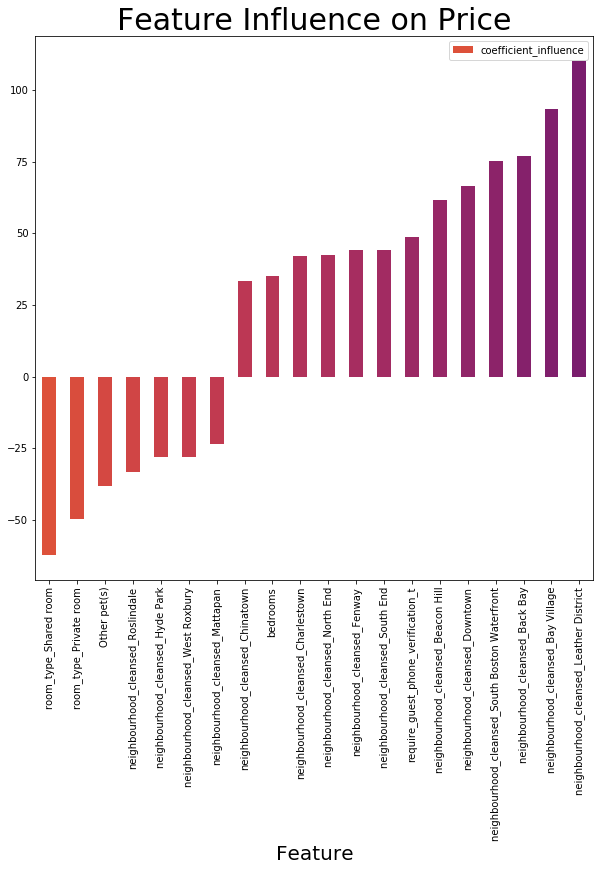

In [51]:
color = plt.cm.inferno_r(np.linspace(.4,.8, 30))
coef_df.head(20).sort_values('coefficient_influence').plot(kind = 'bar', x= 'columns', y='coefficient_influence',figsize=(10,10),color=color)
plt.title('Feature Influence on Price',fontsize=30)
plt.xlabel('Feature',fontsize=20);

With these coefficient weights, I now have the answer to the question. The top five features are all neighborhoods: Leather District, Bay Village, Back Bay, South Boston Waterfront, and Downtown. Other interesting features include the room type of shared room as well as private room, both of which have a negative impact on price. Also, requiring phone verification is an indicator of a higher price, which is probably an indicator of professional renters using Airbnb.

<h2>Question 2 : Can we predict a positive or negative review based on user’s comments ?</h2>

In [4]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kzpul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
rdf = reviews.copy()

In [7]:
rdf= rdf[pd.notnull(rdf['comments'])]

In [8]:
def dectect_language(r):
    try:
        return detect(r)
    except:
        return 'null'     

In [7]:
rdf = rdf[rdf['comments'].apply(dectect_language) == 'en']

In [23]:
rdf.to_csv('./data/reviews_english.csv', sep=',', index=False)

In [11]:
reviews_df = pd.read_csv('./data/reviews_english.csv')

In [12]:
joined_comments = reviews_df.groupby(['listing_id'])['comments'].agg(lambda x: x.tolist())

In [13]:
pscores = [sid.polarity_scores(' '.join(comment)) for comment in joined_comments.values]

In [15]:
scored_reviews = pd.DataFrame()
scored_reviews['id'] = [i for i in joined_comments.index]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [16]:
scored_reviews.head()

,id,compound,negativity,neutrality,positivity
0,3353,1.0,0.033,0.701,0.266
1,5506,1.0,0.015,0.692,0.293
2,6695,1.0,0.023,0.721,0.255
3,6976,1.0,0.016,0.682,0.302
4,8792,1.0,0.009,0.668,0.323


In [31]:
rdf = scored_reviews.join(listings.set_index('id'), on='id')
rdf.dropna(subset=['review_scores_rating'],inplace=True)

In [32]:
y = rdf['review_scores_rating']
X = rdf[['compound', 'negativity', 'neutrality', 'positivity']]

In [33]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.2939656566061566 on 827 values.'